## Matched-filter signal detection on local files with EQcorrscan

In [1]:
# set up logging
import logging

logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

In [2]:
# build catalog of events to use as templates

%matplotlib inline
from obspy import UTCDateTime, Stream, read, read_events

# create HYPODD format file with template events to import them into EQcorrscan
# entries are: #, YR, MO, DY, HR, MN, SC, LAT, LON, DEP, MAG, EH, EZ, RMS, ID 
#              followed by lines of observations: STA, TT, WGHT, PHA
# as specified here: https://www.ldeo.columbia.edu/~felixw/papers/Waldhauser_OFR2001.pdf
# templates start on the times listed and span 16 seconds, locations are made up
templates = ["# 2016  9 26  9 28 11.11  61.8000 -144.0000  30.00  1.00  0.0  0.0  0.00  1\n",
             "RH08   44.180  1       S\n",
             "RH09   44.809  1       S\n",
             "RH10   44.661  1       S\n"]

# now write to file
with open("templates.pha", "w") as file:
    for line in templates:
        file.write(line)

# read the file into an Obspy catalog
catalog = read_events("templates.pha", format="HYPODDPHA")

# complete missing catalog info (information required by EQcorrscan)
# station dict to add data needed by EQcorrscan
station_dict = {"RH08": {"network": "YG", "channel": "BHZ"},
                "RH09": {"network": "YG", "channel": "BHZ"},
                "RH10": {"network": "YG", "channel": "BHZ"}}
# assign network and channel to catalog
for event in catalog.events:
    for pick in event.picks:
        if pick.waveform_id.station_code in station_dict:
            pick.waveform_id.network_code = station_dict[pick.waveform_id.station_code]["network"]
            pick.waveform_id.channel_code = station_dict[pick.waveform_id.station_code]["channel"]

# inspect the contents
catalog[0].picks

[Pick
	 resource_id: ResourceIdentifier(id="smi:local/fbdbb4c1-41a2-4a58-a67d-1946c3e73c67")
	        time: UTCDateTime(2016, 9, 26, 9, 28, 55, 290000)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='RH08', channel_code='BHZ', location_code='')
	  phase_hint: 'S',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/48e5c787-4f15-4c1a-8ed8-840fb13590b2")
	        time: UTCDateTime(2016, 9, 26, 9, 28, 55, 919000)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='RH09', channel_code='BHZ', location_code='')
	  phase_hint: 'S',
 Pick
	 resource_id: ResourceIdentifier(id="smi:local/8c2b8078-723d-4b34-ad01-57e9a1599658")
	        time: UTCDateTime(2016, 9, 26, 9, 28, 55, 771000)
	 waveform_id: WaveformStreamID(network_code='YG', station_code='RH10', channel_code='BHZ', location_code='')
	  phase_hint: 'S']

In [3]:
# download data for specified stations locally to the 'data' directory
from obspy.clients.fdsn import Client

# helper function to download data from IRIS DMC via Obspy
def download_Waveforms(network, stations, location, channels, start_Time, end_Time):
    client = Client("IRIS")
    
    for station in stations:
        for channel in channels:
            st = client.get_waveforms(network, station, location, channel,
                                      start_Time, end_Time)
            # fix rounding errors in sampling rate before merging
            for index, trace in enumerate(st):
                st[index].stats.sampling_rate = round(trace.stats.sampling_rate)

            # do not fill with 0's when using EQcorrscan
            st = st.merge(method=1, fill_value=None)
            
            filename = f"{network}.{station}.{channel}" \
                           f".{start_Time.year}" \
                           f"-{start_Time.month:02}-" \
                           f"{start_Time.day:02}.ms"

            st.write(f"./data/{filename}", format="MSEED")

# 30 days of data are downloaded for three stations in the YG network
network = "YG"
stations = ["RH08", "RH09", "RH10"]
location = "**"
channels = ["BHZ", "BHN", "BHE"]
# the date range
start_Time = UTCDateTime("2016-09-01T00:00:00.0Z")
end_Time =   UTCDateTime("2016-09-30T23:59:59.999999Z")
# update process_len to the duration in seconds
process_len = round(end_Time - start_Time)
download_Waveforms(network, stations, location, channels, start_Time, end_Time)

In [4]:
# load templates from local data and catalog generated above

from eqcorrscan import Tribe
    
# build stream of all stations for detection from 'data' directory
import glob
files_path = "./data"
file_list = glob.glob(f"{files_path}/*.ms")

# load files into stream
st = Stream()
for file in file_list:
    st += read(file)

# bandpass 1-15 Hz, 8 second template + 0.5 prepick = 8.5 second template
tribe = Tribe().construct(
    method="from_meta_file", meta_file=catalog, st=st, lowcut=1.0, highcut=15.0, 
    samp_rate=40.0, length=8.0, filt_order=4, prepick=0.5, swin='all',
    process_len=process_len, parallel=True)
print(tribe)

Tribe of 1 templates


Template 2016_09_26t09_28_54: 
	 3 channels;
	 lowcut: 1.0 Hz;
	 highcut: 15.0 Hz;
	 sampling rate 40.0 Hz;
	 filter order: 4; 
	 process length: 2592000.0 s


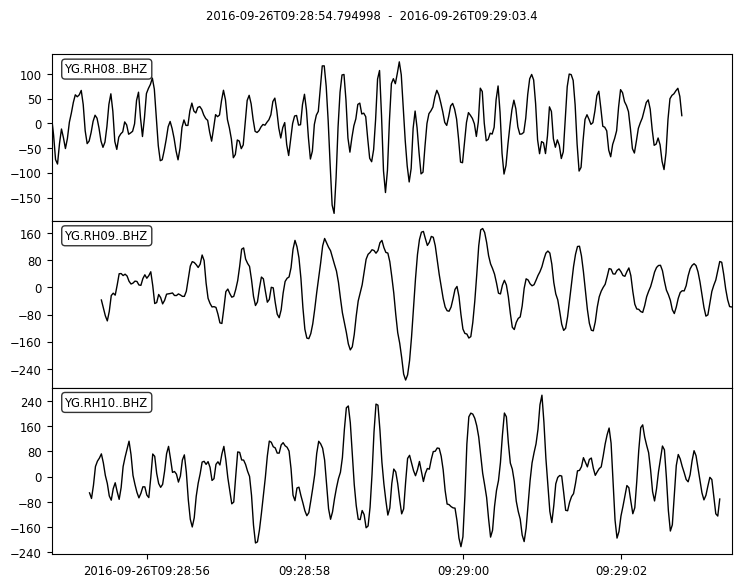

In [5]:
# inspect first template
print(tribe[0])
fig = tribe[0].st.plot(equal_scale=False, size=(800, 600))

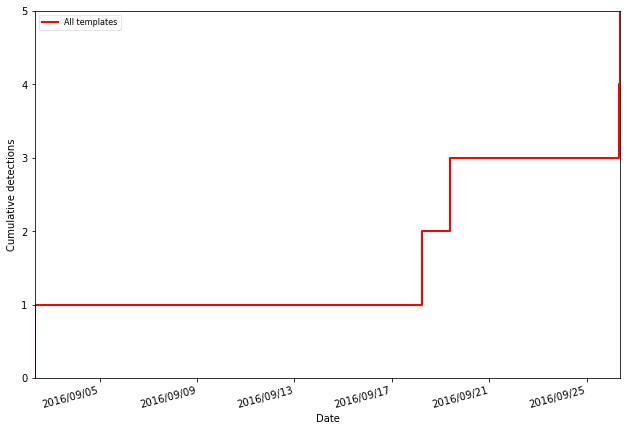

Family of 5 detections from template 2016_09_26t09_28_54


In [6]:
# use tribe to detect events in local data

# detect instances above 8.0x MAD
party = tribe.detect(stream=st, threshold=8.0, daylong=False, threshold_type="MAD", trig_int=8.0,
                     plot=False, return_stream=False, parallel_process=True)

# inspect the party detections
fig = party.plot(plot_grouped=True)

# peek at most productive family
family = sorted(party.families, key=lambda f: len(f))[-1]
print(family)

Detection on template: 2016_09_26t09_28_54 at: 2016-09-02T07:56:37.369998Z with 3 channels: [('RH08', 'BHZ'), ('RH09', 'BHZ'), ('RH10', 'BHZ')]


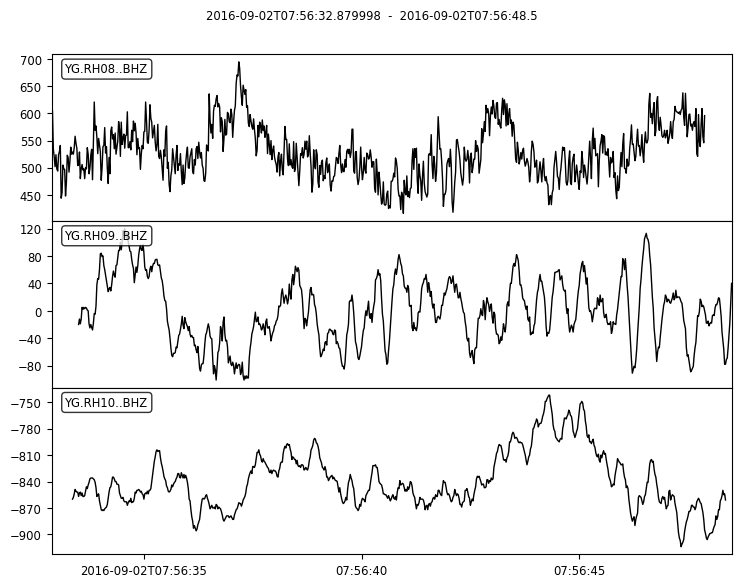

In [7]:
# get a dict of streams for each detection in a family

streams = family.extract_streams(stream=st, length=15, prepick=5.0)
print(family.detections[0])
fig = streams[family.detections[0].id].plot(equal_scale=False, size=(800, 600))